# <span style="color:green"><center>UNIVERSIDAD CENTRAL MAESTRIA EN ANALITICA DE DATOS</center></span>
# <span style="color:green"><center>TERCERA ENTREGA PROYECTO FINAL</center></span>

# <span style="color:red"><center>UNA RED NEURONAL PARA EL PRONOSTICO DE PRODUCCION DE FLORES DE INVERNADERO</center></span>

##   <span style="color:blue">Integrantes:</span>

1. David Augusto Villab´on Borja dvillabonb@ucentral.edu.co
2. Alexis Yesid Tarazona Rincon atarazonar@ucentral.edu.co

## Importar las librería requeridas

In [1]:
#
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from statsmodels.tsa.seasonal import seasonal_decompose

print("Versión de Tensorflow: ", tf.__version__)


Versión de Tensorflow:  2.6.0


# Funciones para graficar predicciones

In [2]:
# Funciones auxiliares
#
def plot_prediction(real, prediccion):
    fig = plt.gcf()
    fig.set_size_inches(15,6)
    plt.plot(real,color='red', label='Valor real')
    plt.plot(prediccion, color='blue', label='Predicción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Predicción de produccion')
    plt.grid()
    plt.legend()
    plt.show()

#

## Lectura de  los datos
Este trabajo contiene dos fuentes de información: 

-	Datos Climáticos, origen estaciones meteorológicas ubicadas en la sabana de Bogotá asociadas a Canal Clima.
-	Datos de producción Real de especies de flor como Sunflower, Campanula y Pompón. 

Las dos bases de datos están indexadas en el tiempo desde el 2017


In [3]:
fileName='Datos_Clima_Diarios_Campanula.csv'
#fileName="/content/drive/MyDrive/Proyecto Redes/Pruebas campanula/Datos_Clima_Diarios_Campanula.csv"
df = pd.read_csv(fileName,sep=';',decimal=",")
print(df.shape)
display(df.head(),df.tail())

(1523, 14)


,Date,Lluvia_mm,Humedad_por,Dir_Viento_Gr,Punto_Rocio_gc,UV_Index,Temperatura_gc,Max.Temperatura_gc,Min.Temperatura_gc,Vel_Viento_km.h,Radiacion_Solar_w.m2,Evapotranspiracion_mm,Presion.Atm_hpa,Tallos.Campanula
0,08/01/2017,6.2,82.973981,197.177206,9.977094,66.481924,13.002846,18.68,9.08485,0.584529,139.233650,1.980445,751.591889,6580
1,08/02/2017,0.0,83.750417,225.107917,10.044583,64.400000,13.012500,21.93,5.50000,0.966667,184.680417,2.710000,752.157689,6010
2,08/03/2017,0.2,83.035417,223.166667,10.110833,75.100000,13.295833,21.72,4.13000,1.579583,192.054583,3.070000,752.849269,4125
3,08/04/2017,2.4,82.370117,186.645833,10.959167,60.500000,13.949949,19.88,9.12000,2.055417,144.846667,2.360000,753.082384,4100
4,08/05/2017,0.0,78.458333,149.881667,10.497500,78.100000,14.477083,20.68,8.48000,2.633437,220.965000,3.510000,753.430000,3960


,Date,Lluvia_mm,Humedad_por,Dir_Viento_Gr,Punto_Rocio_gc,UV_Index,Temperatura_gc,Max.Temperatura_gc,Min.Temperatura_gc,Vel_Viento_km.h,Radiacion_Solar_w.m2,Evapotranspiracion_mm,Presion.Atm_hpa,Tallos.Campanula
1518,09/27/2021,0.0,80.520833,193.667083,10.546204,5105.25,14.094167,20.800000,9.20,1.542500,0.137500,60.1,752.500391,47565
1519,09/28/2021,0.0,84.059167,177.194583,10.595417,2845.08,13.437083,19.170000,9.05,1.764583,0.075417,41.9,751.929167,40600
1520,09/29/2021,0.0,88.708750,170.322917,10.922917,3020.67,12.873750,20.100000,8.73,1.112500,0.077917,40.5,751.720833,33845
1521,09/30/2021,8.0,89.821861,162.222500,11.335833,2280.00,13.416506,19.142092,10.38,0.810000,0.057917,35.2,751.812500,31048
1522,10/01/2021,0.2,94.000000,67.000000,10.030000,0.00,11.000000,11.000000,11.00,0.000000,0.000000,0.0,752.500000,26170


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*.

## Extrae datos para la serie que se desea predecir

In [4]:
# Se crea la data de tal manera que el índice indique el número de dia partir del 2017.
data = pd.DataFrame(df)
#data.index = data['Date'].apply(str)
data = data.sort_index(ascending=True, axis=0)
semanas=list(data['Date'])
data.drop('Date', axis=1, inplace=True)
print(data.shape)
data.head()

(1523, 13)


,Lluvia_mm,Humedad_por,Dir_Viento_Gr,Punto_Rocio_gc,UV_Index,Temperatura_gc,Max.Temperatura_gc,Min.Temperatura_gc,Vel_Viento_km.h,Radiacion_Solar_w.m2,Evapotranspiracion_mm,Presion.Atm_hpa,Tallos.Campanula
0,6.2,82.973981,197.177206,9.977094,66.481924,13.002846,18.68,9.08485,0.584529,139.233650,1.980445,751.591889,6580
1,0.0,83.750417,225.107917,10.044583,64.400000,13.012500,21.93,5.50000,0.966667,184.680417,2.710000,752.157689,6010
2,0.2,83.035417,223.166667,10.110833,75.100000,13.295833,21.72,4.13000,1.579583,192.054583,3.070000,752.849269,4125
3,2.4,82.370117,186.645833,10.959167,60.500000,13.949949,19.88,9.12000,2.055417,144.846667,2.360000,753.082384,4100
4,0.0,78.458333,149.881667,10.497500,78.100000,14.477083,20.68,8.48000,2.633437,220.965000,3.510000,753.430000,3960


### Descomposición de la variable Tallos(Variable objetivo a predecir)

### Tomamos como referencia una serie temporal aditiva

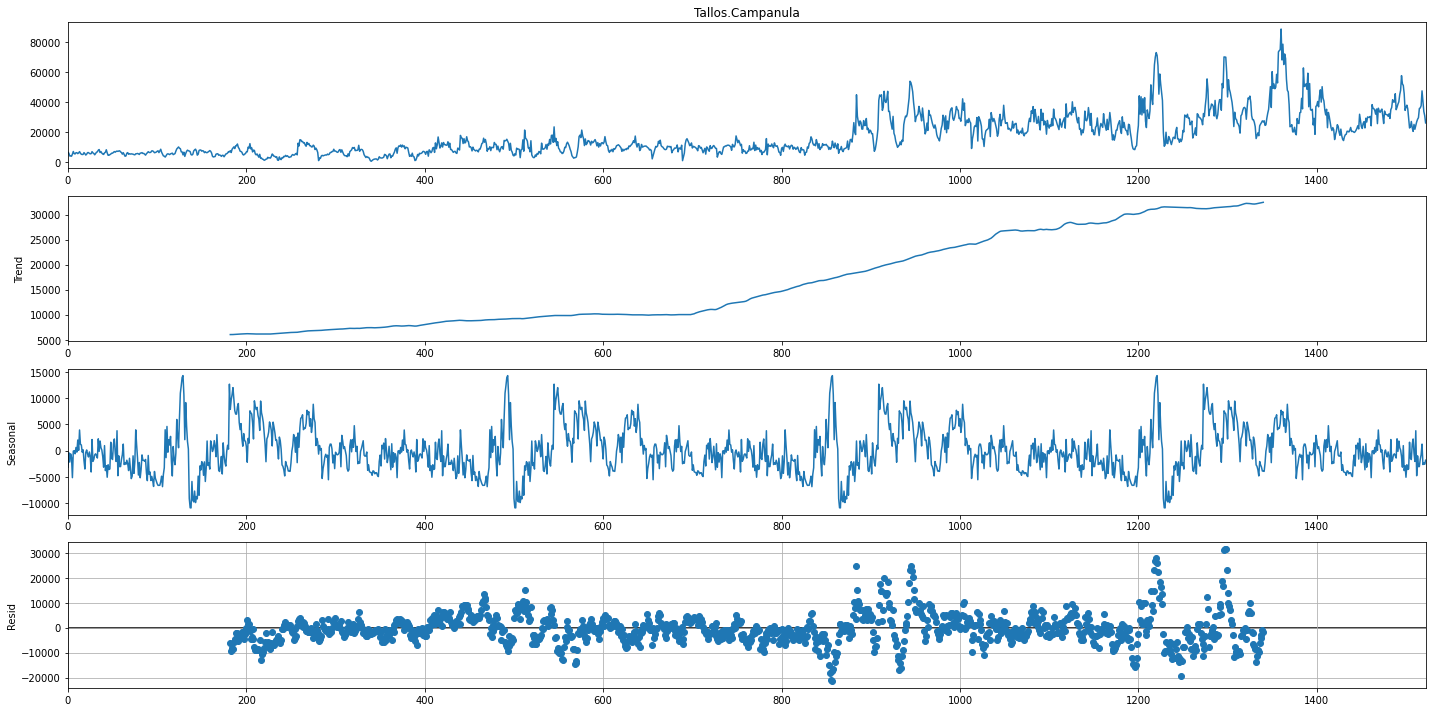

In [14]:
result=seasonal_decompose(data['Tallos.Campanula'], model='aditive',period=364)
result.plot()
plt.grid()
plt.show()

### Normalizamos los datos

In [54]:
#creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


##  Crea datos de entrenamiento 

 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 7 datos (la predicción a
 partir de esos "time_step" datos se hace para el dia siguente). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 7. 
2. Días a predecir: days = 1

In [55]:
# tamaños para entrenamiento y validación
len_train = 1219 # 80%
len_valid = 305 # 20%
len_data = len_train + len_valid

In [56]:
# Longitud de las tiras de datos para hacer las predicciones
time_step = 7
# días a predecir
days = 1

In [57]:
# crea datos de entrenamiento
x_train, y_train = [], []

Ajustamos los datos para nuestros fines, tomando una ventana de 7 dias

In [58]:
for i in range(time_step ,len_train ):
    # x: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_train.append(scaled_data[i-time_step :i,])
    # y: el siguiente dato
    y_train.append(scaled_data[i:i+days,12])



In [59]:
x_train, y_train = np.array(x_train), np.array(y_train)

Tomamos los 7 dias anteriores para predecir el 8 dia

Veamos un ejemplo para los primeros registros:

Variables Predictoras:

Variable a predecir:
Real del dia 8:

In [60]:
# Arregla el tamaño, porque la capa LSTM espera tensores de 7 dimensiones: 
# (batch, longitud de la tira de datos, número de features)
# Como es una serie univariada solamente hay 1 feature.
#
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],13))
y_train = np.reshape(y_train, (y_train.shape[0],1))
#
print(x_train.shape)
print(y_train.shape)

(1212, 7, 13)
(1212, 1)


##  Crea el modelo LSTM

### Redes LSTM

Las LSTM son un tipo especial de redes recurrentes. La característica principal de las redes recurrentes es que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden «recordar» estados previos y utilizar esta información para decidir cuál será el siguiente. Esta característica las hace muy adecuadas para manejar series cronológicas. Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo (es decir, relaciones cercanas en la serie cronológica), las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo.

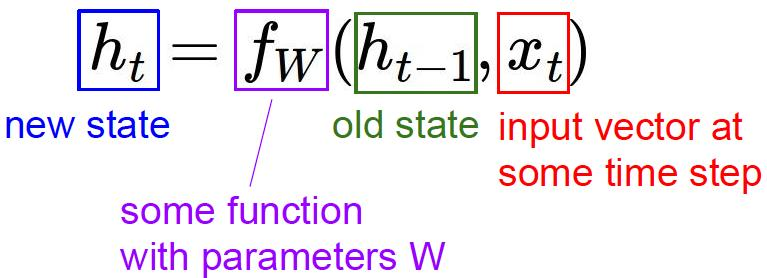

### Busqueda de hiperparametros

In [61]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
import time

In [62]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
kfold = KFold(n_splits=4, random_state=1, shuffle=True)

In [ ]:
def createLSTMModel(optimizer='adam', activation='relu', loss='mae', n_jobs=-1,dropout_rate=0.1):

  units = 70
  #
  model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units=units,activation=activation, return_sequences=True, input_shape=(x_train.shape[1],13)),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.LSTM(units=units),
  tf.keras.layers.Dense(1)])
  model.compile(loss=loss, optimizer=optimizer)

  return model

In [ ]:
grid_param_LSTM = {'batch_size': [348,256,200,128],
                   'epochs': [30,50,100],
                   'optimizer': ['RMSProp','adam'],
                   'loss': ['logcosh', 'mae', 'mse', 'hinge','squared_hinge'],
                   'activation': ['relu','sigmoid','hard_sigmoid', 'tanh'],
                   'dropout_rate':[0.1,0.2,0.5]
                  }
model_LSTM = KerasRegressor(build_fn=createLSTMModel)
GridLSTM = GridSearchCV(estimator=model_LSTM,
                     param_grid=grid_param_LSTM,
                     scoring={'neg_mean_squared_error','r2','explained_variance','max_error','neg_mean_absolute_error','neg_median_absolute_error'},
                     refit='neg_median_absolute_error',
                     cv=kfold)

GridLSTM.fit(x_train,y_train)

In [23]:
results = GridLSTM.cv_results_
print("\n Mejor desempeño: ", GridLSTM.best_score_)
print("\n Mejores hiper parámetros:\n",GridLSTM.best_params_)

#tiempo_ejecucion = tiempo_final - tiempo_inicial
#print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))

df = pd.DataFrame(results)
df.head()


 Mejor desempeño:  -0.015417968163833999

 Mejores hiper parámetros:
 {'activation': 'tanh', 'batch_size': 128, 'dropout_rate': 0.1, 'epochs': 100, 'loss': 'mae', 'optimizer': 'adam'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_dropout_rate,param_epochs,param_loss,param_optimizer,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_max_error,split1_test_max_error,split2_test_max_error,split3_test_max_error,mean_test_max_error,std_test_max_error,rank_test_max_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_test_explained_variance,split1_test_explained_variance,split2_test_explained_variance,split3_test_explained_variance,mean_test_explained_variance,std_test_explained_variance,rank_test_explained_variance,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,10.846330,1.527864,0.641217,0.029604,relu,256,0.1,30,mae,RMSProp,"{'activation': 'relu', 'batch_size': 256, 'dro...",-0.004191,-0.006306,-0.003753,-0.004692,-0.004735,0.000966,94,-0.046058,-0.055976,-0.048607,-0.048100,-0.049685,0.003755,92,-0.305006,-0.397119,-0.267622,-0.347324,-0.329268,0.048266,87,-0.033777,-0.038090,-0.044260,-0.034541,-0.037667,0.004140,92,0.725193,0.749490,0.753241,0.725638,0.738391,0.013043,94,0.682784,0.552798,0.702578,0.615075,0.638309,0.059077,92
1,10.781933,1.976908,0.645319,0.023803,relu,256,0.1,30,mae,adam,"{'activation': 'relu', 'batch_size': 256, 'dro...",-0.003322,-0.002843,-0.002531,-0.002927,-0.002906,0.000282,49,-0.038195,-0.035657,-0.033819,-0.037451,-0.036281,0.001695,48,-0.293892,-0.331549,-0.265413,-0.258435,-0.287322,0.028782,58,-0.026680,-0.024787,-0.022224,-0.025489,-0.024795,0.001631,46,0.762177,0.800871,0.801070,0.759885,0.781001,0.019986,65,0.748492,0.798361,0.799426,0.759862,0.776535,0.022720,49
2,10.074483,0.329181,0.646498,0.016767,relu,256,0.1,30,mse,RMSProp,"{'activation': 'relu', 'batch_size': 256, 'dro...",-0.004095,-0.005152,-0.002689,-0.003816,-0.003938,0.000876,79,-0.037142,-0.060681,-0.035899,-0.049805,-0.045882,0.010130,86,-0.378255,-0.281102,-0.286785,-0.276995,-0.305784,0.041985,78,-0.020524,-0.057128,-0.024648,-0.042474,-0.036194,0.014633,88,0.712605,0.794702,0.786921,0.745196,0.759856,0.033145,85,0.689994,0.634690,0.786870,0.686937,0.699623,0.054959,78
3,9.953020,0.234451,0.635874,0.017839,relu,256,0.1,30,mse,adam,"{'activation': 'relu', 'batch_size': 256, 'dro...",-0.003373,-0.002858,-0.002821,-0.002729,-0.002945,0.000251,53,-0.035037,-0.036294,-0.036252,-0.036848,-0.036108,0.000661,43,-0.335466,-0.338191,-0.282709,-0.251474,-0.301960,0.036588,74,-0.022253,-0.024682,-0.022401,-0.024909,-0.023561,0.001238,39,0.744672,0.797531,0.780367,0.776605,0.774794,0.019096,72,0.744666,0.797327,0.776426,0.776096,0.773629,0.018804,51
4,10.369385,0.231581,0.780996,0.161012,relu,256,0.1,30,hinge,RMSProp,"{'activation': 'relu', 'batch_size': 256, 'dro...",-252.484402,-336.323632,-323.093054,-268.735095,-295.159046,35.334765,103,-15.889343,-18.338745,-17.974440,-16.392770,-17.148824,1.031439,103,-16.031851,-18.488060,-18.118423,-16.544931,-17.295816,1.031936,103,-15.927112,-18.376902,-18.013866,-16.428941,-17.186705,1.032176,103,0.001935,0.003027,0.003432,0.000990,0.002346,0.000956,119,-19111.734681,-23848.625929,-25604.545958,-22047.331944,-22653.059628,2400.444685,103


In [117]:
units = 70

mejor_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=units,
                         activation='tanh', 
                         return_sequences=True, 
                         input_shape=(x_train.shape[1],13)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=units),
    tf.keras.layers.Dense(1)])

mejor_model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])

mejor_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 70)             23520     
_________________________________________________________________
dropout (Dropout)            (None, 7, 70)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 71        
Total params: 63,071
Trainable params: 63,071
Non-trainable params: 0
_________________________________________________________________


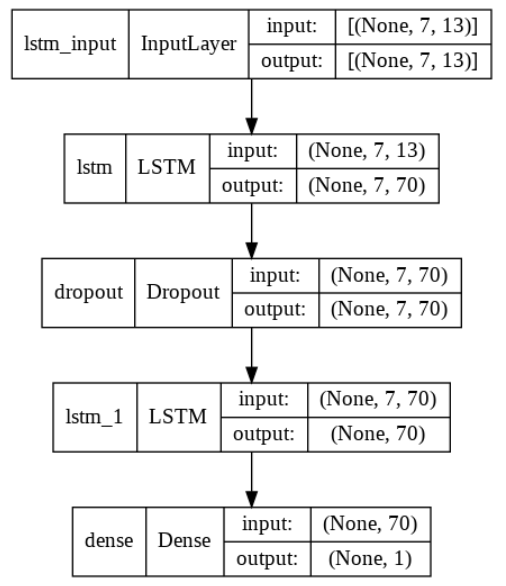

# Entrena el modelo


In [148]:
#history = mejor_model.fit(x_train,y_train,epochs=100,batch_size=128,validation_split=0.05, verbose=1,
 #         callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

history = mejor_model.fit(x_train,y_train,epochs=100,batch_size=128,validation_split=0.05, verbose=0)

Veamos La perdida(Loss) del modelo

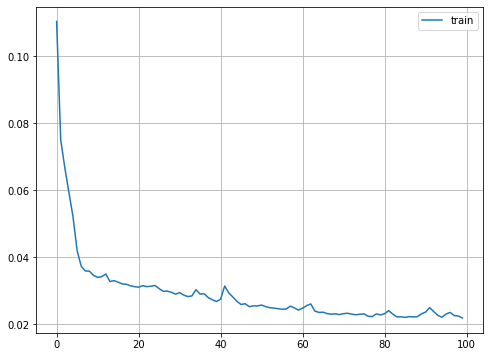

In [149]:
plt.plot(history.history['loss'], label='train')
plt.grid()
plt.legend();

## Predicciones

### Prepara los datos de validación

In [150]:
inputs = data[len_data - len_valid - time_step:].values
inputs = inputs.reshape(-1,13)
inputs  = scaler.transform(inputs)

x_test = []
y_test = []

# aqui vamos

for i in range(time_step,inputs.shape[0]):
    x_test.append(inputs[i-time_step:i,])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],13))

y_test=scaled_data[1219:,12]

In [151]:
# predictions
prediction = mejor_model.predict(x_test)

### Calcula predicciones

In [152]:
mi=data.iloc[:, 12].min()
ma=data.iloc[:, 12].max()
Rango=ma-mi

In [153]:
prediction=prediction*Rango+mi

In [154]:
set_validation = data[len_data - len_valid :]

In [155]:
er=prediction-set_validation


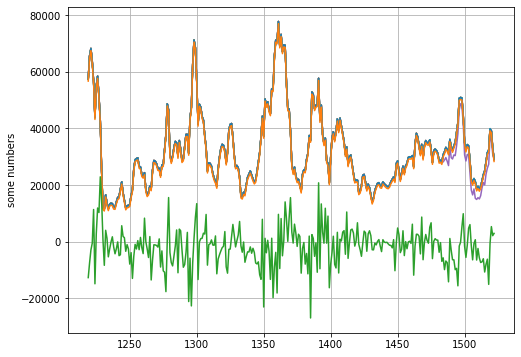

In [156]:
plt.plot(er)
plt.ylabel('some numbers')
plt.grid()
plt.show()

### Gráfica de las predicciones

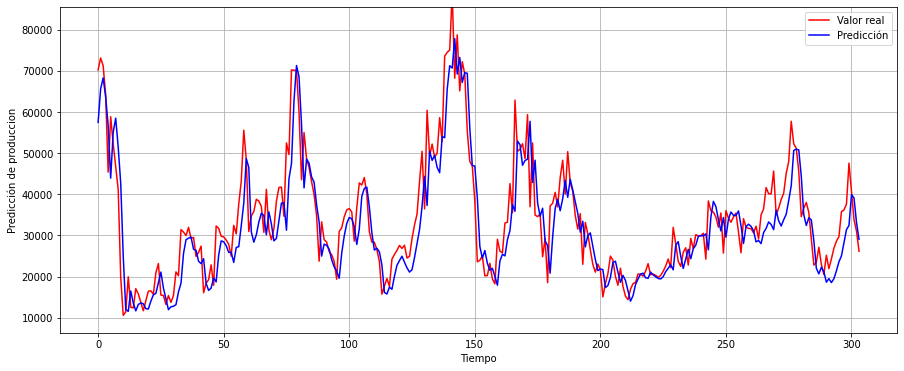

In [245]:
# Graficar resultadosdata[len_data - len_valid - time_step:].valuesdata['Close'][987:]
set_validation = data.iloc[len_data - len_valid:,12].values
plot_prediction(set_validation,prediction)


In [158]:
train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])
valid['Predictions'] = prediction

In [159]:
valid

,Lluvia_mm,Humedad_por,Dir_Viento_Gr,Punto_Rocio_gc,UV_Index,Temperatura_gc,Max.Temperatura_gc,Min.Temperatura_gc,Vel_Viento_km.h,Radiacion_Solar_w.m2,Evapotranspiracion_mm,Presion.Atm_hpa,Tallos.Campanula,Predictions
1219,0.0,86.253750,159.051667,11.320833,48.90,13.767500,19.830000,10.20,1.754583,143.916250,2.27,750.941667,70220,57473.132803
1220,0.2,85.309167,124.552083,11.614583,38.50,14.141250,18.850000,11.30,1.961250,120.437500,1.87,750.966667,73120,65602.923106
1221,0.0,84.788333,167.371667,11.077500,65.30,13.986250,21.570000,8.88,1.519583,230.735833,3.42,751.433333,71260,68285.595242
1222,0.0,83.347083,142.468750,9.361667,52.20,12.395000,18.850000,5.23,2.112083,167.513750,2.76,752.266667,64250,63679.192080
1223,0.0,82.250000,203.552083,9.047917,53.10,12.352083,19.180000,4.73,2.011250,175.583333,2.91,751.616667,45390,56719.296312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,0.0,80.520833,193.667083,10.546204,5105.25,14.094167,20.800000,9.20,1.542500,0.137500,60.10,752.500391,47565,32424.542415
1519,0.0,84.059167,177.194583,10.595417,2845.08,13.437083,19.170000,9.05,1.764583,0.075417,41.90,751.929167,40600,39908.093182
1520,0.0,88.708750,170.322917,10.922917,3020.67,12.873750,20.100000,8.73,1.112500,0.077917,40.50,751.720833,33845,39129.578226
1521,8.0,89.821861,162.222500,11.335833,2280.00,13.416506,19.142092,10.38,0.810000,0.057917,35.20,751.812500,31048,33127.972106


Guardamos el dadta frame de predicciones

In [160]:
from openpyxl.workbook import Workbook
valid.to_excel('Predicciones_ltsm.xlsx', sheet_name='example')

Calculamos el 'mae'

In [167]:
maeLSTM = np.mean(abs(valid['Tallos.Campanula'].values-valid['Predictions'].values))
maeLSTM 

5142.084927461748

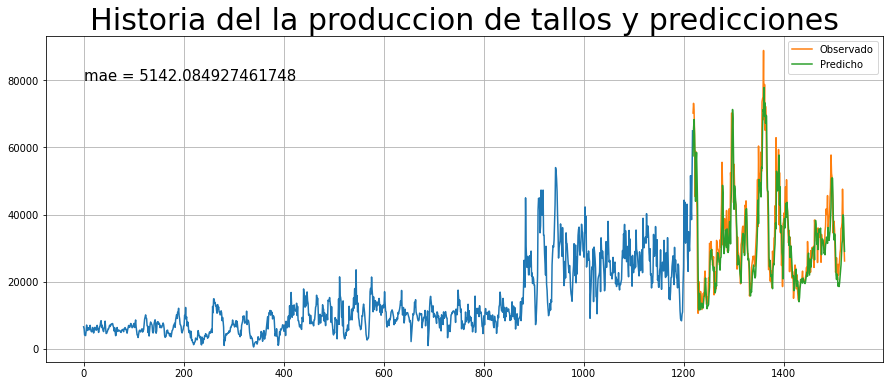

In [175]:
train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])

fig = plt.gcf()
fig.set_size_inches(15,6)

valid['Predictions'] = prediction
plt.plot(train['Tallos.Campanula'])
plot = plt.plot(valid[['Tallos.Campanula','Predictions']])
plt.annotate("mae = "+str(maeLSTM) , xy=(1,80000), size = 15)
plt.legend(plot, ("Observado","Predicho"))
plt.title("Historia del la produccion de tallos y predicciones", size = 30)
plt.grid()
plt.show()

Guardamos el modelo

In [82]:
mejor_model.save_weights("my_model.h5")

Para Cargar nuevamente el modelo:

In [ ]:
modelD.load_weights("my_model.h5")

### Modelo de perceptron Multicapa:

In [220]:
# define network architecture
model_MLP =tf.keras.models.Sequential([
    tf.keras.layers.Dense(70, activation='tanh', input_shape=(7*13,)),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(1)])

In [221]:
model_MLP.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 70)                6440      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                3550      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 10,041
Trainable params: 10,041
Non-trainable params: 0
_________________________________________________________________


In [222]:
print('\nTamaño original de las entradas de entrenamiento:\t',x_train.shape)
train_tallos = x_train.reshape((1212, 7*13))
print('\nTamaño vectorizado de las entradas de entrenamiento:\t',train_tallos.shape)

train_tallos = train_tallos.astype('float32') 



Tamaño original de las entradas de entrenamiento:	 (1212, 7, 13)

Tamaño vectorizado de las entradas de entrenamiento:	 (1212, 91)


In [223]:
model_MLP.compile(optimizer='adam',
                loss='mae',
                metrics='mse')

In [224]:
train_labels = y_train.astype('float32')

In [225]:
model_x_lotes= model_MLP.fit(train_tallos,train_labels, epochs=15, batch_size=128, validation_split=0.05,verbose=0)

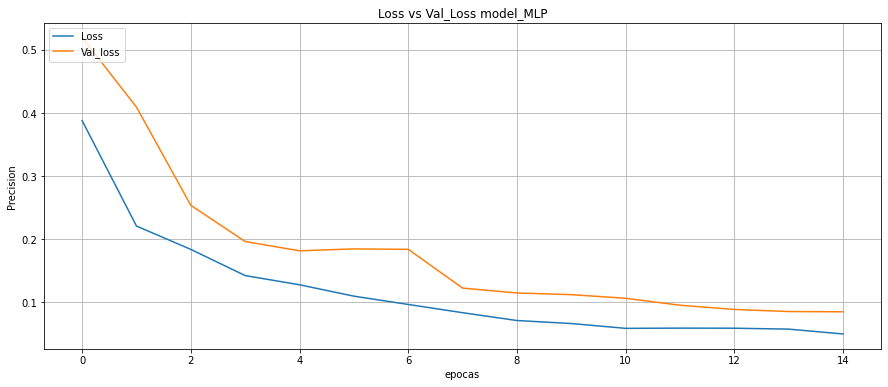

In [246]:
fig = plt.gcf()
fig.set_size_inches(15,6)
plt.plot(model_x_lotes.history['loss'])
plt.plot(model_x_lotes.history['val_loss'])
plt.title('Loss vs Val_Loss model_MLP')
plt.ylabel('Precision')
plt.xlabel('epocas')
plt.legend(['Loss', 'Val_loss'], loc='upper left')
plt.grid()
plt.show()

<Figure size 1080x432 with 0 Axes>

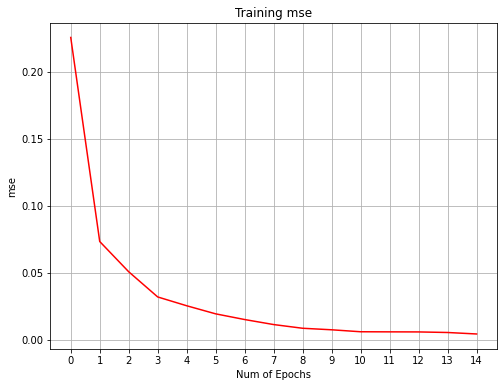

In [249]:
fig = plt.gcf()
fig.set_size_inches(15,6)
plt.figure(0)  
plt.plot(model_x_lotes.history['mse'],'r')  
plt.xticks(np.arange(0, 15, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("mse")  
plt.title("Training mse") 
plt.grid()
plt.show()  

In [229]:
print('\nTamaño original de las entradas de entrenamiento:\t',x_test.shape)
test_tallos = x_test.reshape((304, 7*13))
print('\nTamaño vectorizado de las entradas de entrenamiento:\t',test_tallos.shape)

test_tallos= test_tallos.astype('float32') 



Tamaño original de las entradas de entrenamiento:	 (304, 7, 13)

Tamaño vectorizado de las entradas de entrenamiento:	 (304, 91)


In [94]:
test_labels= y_test.astype('float32')

In [233]:
# Probamos la RNA en datos que no conoce 
test_loss, test_mae = model_MLP.evaluate(test_tallos, test_labels)
print('')
print('test_mae:', test_mae)

10/10 [==============================] - 0s 2ms/step - loss: 0.0922 - mse: 0.0149

test_mae: 0.014909219928085804


In [234]:
prediction_PM = model_MLP.predict(test_images)

In [235]:
mi=data.iloc[:, 12].min()
ma=data.iloc[:, 12].max()
Rango=ma-mi

In [237]:
prediction_PM=prediction_PM*Rango+mi

In [238]:
set_validation1 = data[len_data - len_valid :]

In [239]:
train_PER = pd.DataFrame(data[:len_train])
valid_PER = pd.DataFrame(data[len_train:])
valid_PER['Predictions'] =prediction_PM

In [240]:
valid_PER

,Lluvia_mm,Humedad_por,Dir_Viento_Gr,Punto_Rocio_gc,UV_Index,Temperatura_gc,Max.Temperatura_gc,Min.Temperatura_gc,Vel_Viento_km.h,Radiacion_Solar_w.m2,Evapotranspiracion_mm,Presion.Atm_hpa,Tallos.Campanula,Predictions
1219,0.0,86.253750,159.051667,11.320833,48.90,13.767500,19.830000,10.20,1.754583,143.916250,2.27,750.941667,70220,40577.269299
1220,0.2,85.309167,124.552083,11.614583,38.50,14.141250,18.850000,11.30,1.961250,120.437500,1.87,750.966667,73120,52038.018385
1221,0.0,84.788333,167.371667,11.077500,65.30,13.986250,21.570000,8.88,1.519583,230.735833,3.42,751.433333,71260,46246.848879
1222,0.0,83.347083,142.468750,9.361667,52.20,12.395000,18.850000,5.23,2.112083,167.513750,2.76,752.266667,64250,60330.993367
1223,0.0,82.250000,203.552083,9.047917,53.10,12.352083,19.180000,4.73,2.011250,175.583333,2.91,751.616667,45390,56843.449073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,0.0,80.520833,193.667083,10.546204,5105.25,14.094167,20.800000,9.20,1.542500,0.137500,60.10,752.500391,47565,24704.813545
1519,0.0,84.059167,177.194583,10.595417,2845.08,13.437083,19.170000,9.05,1.764583,0.075417,41.90,751.929167,40600,26396.476476
1520,0.0,88.708750,170.322917,10.922917,3020.67,12.873750,20.100000,8.73,1.112500,0.077917,40.50,751.720833,33845,42832.787421
1521,8.0,89.821861,162.222500,11.335833,2280.00,13.416506,19.142092,10.38,0.810000,0.057917,35.20,751.812500,31048,49064.330326


In [241]:
valid_PER.to_excel('Predicciones_PER.xlsx', sheet_name='example')

In [242]:
maePER = np.mean(abs(valid_PER['Tallos.Campanula'].values-valid_PER['Predictions'].values))
maePER

8137.70697737272

### Gráfica de las predicciones

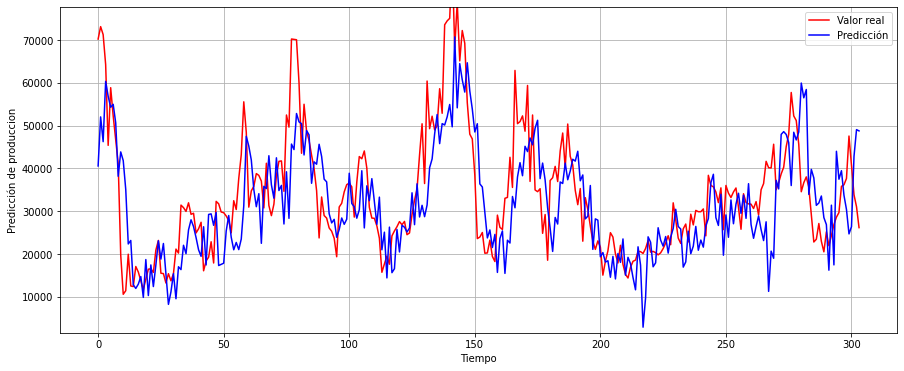

In [250]:
# Graficar resultadosdata[len_data - len_valid - time_step:].valuesdata['Close'][987:]
set_validation1 = data.iloc[len_data - len_valid:,12].values
plot_prediction(set_validation1,prediction_PM)


## References

1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
3. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
4. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
5. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
6. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
7. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
8. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md